In [43]:
import os
import torch
os.environ['TORCH'] = torch.__version__
import torch_geometric

## Install required packages.
# %pip install -q torch-scatter
# %pip install -q torch-sparse
# %pip install torch-geometric

In [44]:
from sklearn.metrics import roc_auc_score

import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Graph autoencoder for link prediction


Reference: [code](https://github.com/rusty1s/pytorch_geometric/blob/master/examples/link_pred.py)


In [45]:
# input example
import torch
from torch_geometric.data import Data

users = ['user1', 'user2', 'user3', 'user4', 'user5', 'user6']
hashtags = ['#food', '#travel', '#fashion', '#fitness', '#nature', '#art', '#music']

user_nodes = torch.tensor([0, 1, 2, 3, 4, 5], dtype=torch.long) # user node indices
hashtag_nodes = torch.tensor([6, 7, 8, 9, 10, 11, 12], dtype=torch.long) # hashtag node indices

x = torch.zeros((len(users) + len(hashtags), 1)) # initialize node features
x[user_nodes, 0] = 1 # set user node features to 1
x[hashtag_nodes, 0] = -1 # set hashtag node features to -1

# The following edges are directed edges from users to hashtags using indices.
# (e.g. the first edge is from user1 to #food, the second edge is from user2 to #travel, etc.)
edges = torch.tensor([[0, 6], [0, 7], [1, 8], [2, 9], [2, 8], [3, 7], [4, 6], [5, 10], [5, 11], [5, 12]
], dtype=torch.long) # edge index

data = Data(x=x, edge_index=edges.t().contiguous()) # x has shape [13, 1], edge_index has shape [2, 10]

In [46]:
# load data
from torch_geometric.transforms import RandomLinkSplit

transform = T.Compose([T.ToDevice(device), RandomLinkSplit(num_val=0.1, num_test=0.2, is_undirected=True, add_negative_train_samples=False)])
train_data, val_data, test_data = transform(data)

print(train_data)
print(val_data)
print(test_data)

Data(x=[13, 1], edge_index=[2, 14], edge_label=[7], edge_label_index=[2, 7])
Data(x=[13, 1], edge_index=[2, 14], edge_label=[2], edge_label_index=[2, 2])
Data(x=[13, 1], edge_index=[2, 16], edge_label=[4], edge_label_index=[2, 4])


#### Simple autoencoder model
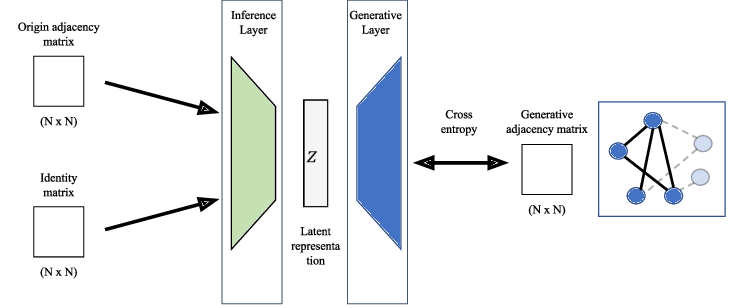

Encoder(Inference): Two layer Graph convolutional layer

Decoder(Generative): Pair-wise inner product of node imbeddings

[BCEWithLogitsLoss](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html): This loss combines a Sigmoid layer and the Binary Cross Entropy. 

In [49]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        #return the indices of a non-zero element
        return (prob_adj > 0).nonzero(as_tuple=False).t()

In [50]:
num_features = data.x.shape[1]
model = Net(num_features, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

#### Model Training
Training with new negative samples for each training epoch

Validation/Test evaluation with roc_auc_score (Area Under the Receiver Operating Characteristic Curve)

In [65]:
def train(EPOCHS = 100):
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_index.size(1))
        # num_neg_samples=train_data.edge_label_index.size(1))

    edge_label_index = torch.cat(
        [train_data.edge_index, neg_edge_index],
        # [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    
    train_edge_label = torch.ones(train_data.edge_index.size(1))
    edge_label = torch.cat([
        # train_data.edge_label,
        # train_data.edge_label.new_zeros(neg_edge_index.size(1))
        train_edge_label,
        train_edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)
    
    best_val_auc = 0
    for epoch in range(EPOCHS):
        # training
        model.train()
        optimizer.zero_grad()
        out = model.decode(z, train_data.edge_index).view(-1)
        # out = model.decode(z, edge_label_index).view(-1)
        loss = criterion(out, edge_label)
        loss.backward()
        optimizer.step()
        
        # validation
        with torch.no_grad():
            model.eval()
            # z = model.encode(data.x, data.edge_index)
            # out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
            out = model.decode(z, data.edge_index).view(-1).sigmoid()
            val_edge_label = torch.ones(val_data.edge_index.size(1))
            val_auc = roc_auc_score(val_edge_label.cpu().numpy(), out.cpu().numpy())
            # val_auc = roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())
            if val_auc > best_val_auc:
                best_val_auc = val_auc
                best_model = model.state_dict()
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val AUC: {val_auc:.4f}')
            
    # testing
    with torch.no_grad():
        model.load_state_dict(best_model)
        model.eval()
        z = model.encode(data.x, data.edge_index)
        out = model.decode(z, data.edge_index).view(-1).sigmoid()
        # out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
        # test_auc = roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())
        test_edge_label = torch.ones(test_data.edge_index.size(1))
        test_auc = roc_auc_score(test_edge_label.cpu().numpy(), out.cpu().numpy())
        print(f'Test AUC: {test_auc:.4f}')

# @torch.no_grad()
# def test(data):
#     model.eval()
#     z = model.encode(data.x, data.edge_index)
#     out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
#     return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())

In [66]:
# best_val_auc = final_test_auc = 0
# for epoch in range(1, 101):
#     loss = train()
#     val_auc = test(val_data)
#     test_auc = test(test_data)
#     if val_auc > best_val_auc:
#         best_val = val_auc
#         final_test_auc = test_auc
#     print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
#           f'Test: {test_auc:.4f}')

# print(f'Final Test: {final_test_auc:.4f}')

train()

ValueError: Target size (torch.Size([28])) must be the same as input size (torch.Size([14]))

In [ ]:
z = model.encode(test_data.x, test_data.edge_index)
final_edge_index = model.decode_all(z)
print(final_edge_index)

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  2,  2,  2,  2,  2,
          2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  5,  5,
          5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,
          6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
          8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10,
         10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
         11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12],
        [ 0,  2,  3,  5,  6,  7,  8,  9, 10, 11, 12,  1,  4,  0,  2,  3,  5,  6,
          7,  8,  9, 10, 11, 12,  0,  2,  3,  5,  6,  7,  8,  9,  1,  4,  0,  2,
          3,  5,  6,  7,  8,  9, 10, 11, 12,  0,  2,  3,  5,  6,  7,  8,  9, 10,
         11, 12,  0,  2,  3,  5,  6,  7,  8,  9, 10, 11, 12,  0,  2,  3,  5,  6,
          7,  8,  9, 10, 11, 12,  0,  2,  3,  5,  6,  7,  8,  9, 10, 11, 12,  0,
          2,  5,  6,  7,  8,  9, 10, 11, 12,  0,  2,  5

In [ ]:
# extract embeddings of the two nodes participating in each edge
node_embeddings = model.encode(test_data.x, test_data.edge_index)
edge_embeddings = torch.cat((node_embeddings[final_edge_index[0]], node_embeddings[final_edge_index[1]]), dim=-1)

# compute dot product between node embeddings
dot_product = torch.sum(edge_embeddings[:, :128] * edge_embeddings[:, 128:], dim=-1)

# pass dot product through sigmoid function
probabilities = torch.sigmoid(dot_product)

# threshold probabilities to classify links as present or absent
predictions = (probabilities >= 0.5).long()


RuntimeError: The size of tensor a (128) must match the size of tensor b (0) at non-singleton dimension 1